<a href="https://colab.research.google.com/github/tjturnage/Google-Colab_Notebooks/blob/main/kml_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>DAT storm survey paths/polygons to GR2Analyst placefiles conversion script.</h1>




1.   Go to the [NWS Damage Viewer](https://apps.dat.noaa.gov/stormdamage/damageviewer/) or the [damage editor site](https://apps.dat.noaa.gov/StormDamage/DamageEditor/) to select your features.

2.  Download your features as a kmz ensuring only paths and/or polygons were selected.

3. Click the folder icon on the left and drag your downloaded file into the region under the "sample_data" folder.

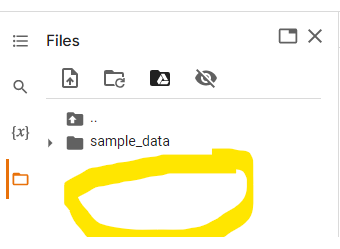

In [ ]:
#@title Shouldn't need to change this name since it's the default the DAT gives
kmz_filename = 'storm_survey.kmz' #@param {type:"string"}


In [ ]:
#@title Edit information below. This will be used in placefile title.
date = "31 March 2023 Midwest Outbreak" #@param {type:"string"}
WFO = "Multi WFO" #@param {type:"string"}


In [ ]:
#@title Select which placefiles to create. Each will be a separate file.
polygon = True #@param {type:"boolean"}
path = True #@param {type:"boolean"}

Run the cell below. After it completes, you should see two or three new files listed to the left. Ignore "doc.kml" but right-click on "polygon_placefile" and/or "line_placefile" to download them. Once they are downloaded, they can be added to GR2Analyst.

In [ ]:
#@title
import zipfile

class Damage_Plot():

  def __init__(self, polygon, linestring):
    self.polygon = polygon
    self.linestring = linestring
    self.coord_tag = False
    self.polygon_tag = False
    self.linestring_tag = False
    self.start_output_files()
    self.unzip_kml()
    self.readlines()
    self.file_close()

  def start_output_files(self):
    threshold_line = 'Threshold: 999\n'
    refresh_line = '\nRefresh: 10\n'
    if self.polygon:
      self.polygon_file = open('polygon_placefile','w')
      self.polygon_file.write(f'Title: {WFO} -- {date} -- Polygons\nRefresh: 10\n')
      self.polygon_file.write(threshold_line)
    if self.linestring:
      self.path_file = open('line_placefile','w')
      self.path_file.write(f'Title: {WFO} -- {date} -- Paths\nRefresh: 10\n')
      self.path_file.write(threshold_line)
    return

  def unzip_kml(self):
    """
    Unzips kmz to a file called 'doc.kml' by default
    """
    with zipfile.ZipFile('storm_survey.kmz', 'r') as zip_ref:
      zip_ref.extractall('.')
    return

  def readlines(self):
    with open('doc.kml','r') as fin:
      for line in fin.readlines():
        if 'styleUrl' in line:
          if '5' in line:
            hover_text = 5
            color_line = 'Color: 168 10 132\n'
          elif '4' in line:
            hover_text = 4
            color_line = 'Color: 230 0 0\n'
          elif '3' in line:
            hover_text = 3
            color_line = 'Color: 230 152 6\n'
          elif '2' in line:
            hover_text = 2
            color_line = 'Color: 255 253 29\n'
          elif '1' in line:
            hover_text = 1
            color_line = 'Color: 85 253 34\n'
          else:
            hover_text = 0
            color_line = 'Color: 6 254 197\n'

        elif 'Event Date' in line:
          try:
            test = line.split('<td>')
            date_string = test[-1][:-6]
            #print(date_string)
          except:
            date_string = 'date unavailable'

        elif ('<LineString>' in line and self.linestring):
          self.linestring_tag = True
          self.polygon_tag = False

        elif ('<Polygon>' in line and self.polygon):
          self.polygon_tag = True
          self.linestring_tag = False

        elif '<coordinates>' in line:
          self.coord_tag = True
          feature_text = f'{color_line}Line: 1, 0, " EF{hover_text} -- {date_string} "\n'
          if self.linestring_tag and self.linestring:
            self.path_file.write(feature_text)
          if self.polygon_tag and self.polygon:
            self.polygon_file.write(feature_text)

        elif '</coordinates>' in line:
          end_text = f'End:\n\n'
          if self.linestring_tag and self.linestring:
            self.path_file.write(end_text)
          if self.polygon_tag and self.polygon:
            self.polygon_file.write(end_text)

          self.coord_tag = False
          self.linestring_tag = False
          self.polygon_tag = False

        elif self.coord_tag:   
          try:
            lon,lat,zero = line.split(',')
            coordinate_text = f' {float(lat):.5f}, {float(lon):.5f}\n'
            #print(text)
            if self.linestring_tag and self.linestring:
              self.path_file.write(coordinate_text)
            if self.polygon_tag and self.polygon:
              self.polygon_file.write(coordinate_text)
          except:
            pass

        else:
          pass

    return

  def file_close(self):
    try:
      self.polygon_file.close()
    except:
      pass
    try:
      self.path_file.close()
    except:
      pass

    return

if __name__ == "__main__":
    Damage_Plot(polygon, path)